Found 2028 files belonging to 9 classes.
Found 292 files belonging to 9 classes.
Epoch 1/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - accuracy: 0.6415 - loss: 1.0276 - val_accuracy: 0.6130 - val_loss: 1.0916 - learning_rate: 1.0000e-04
Epoch 2/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.7811 - loss: 0.6252 - val_accuracy: 0.7637 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 3/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.8432 - loss: 0.4481 - val_accuracy: 0.8425 - val_loss: 0.5509 - learning_rate: 1.0000e-04
Epoch 4/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.8782 - loss: 0.3517 - val_accuracy: 0.8253 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 5/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 630s 5s/step - accuracy: 0.8994 - loss: 0.3199 - val_accuracy: 0.8322 - val_loss: 0.4989 - learning_rate: 1.0000e-04
Epoch 6/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 591s 5s/step - accuracy: 0.9152 - loss: 0.2639 - val_accuracy: 0.8938 - val_loss: 0.3278 - learning_

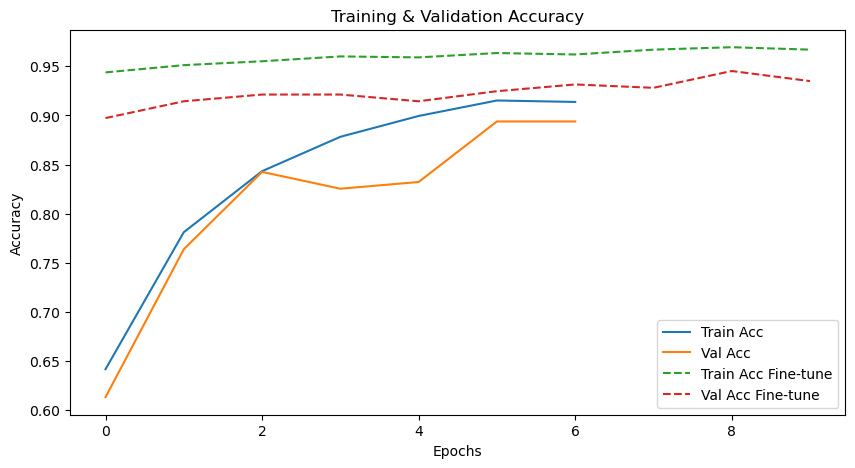

In [2]:
# ==============================
# IMPORTS
# ==============================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==============================
# SETTINGS
# ==============================
IMAGE_SIZE = 224        # VGG16 recommended
BATCH_SIZE = 16
EPOCHS = 7

train_dir = 'skin-disease-datasaet/train_set'
val_dir = 'skin-disease-datasaet/test_set'  # validation/test data

# ==============================
# DATASET LOAD
# ==============================
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
num_classes = len(class_names)

# ==============================
# DATA PREPROCESSING + AUGMENTATION
# ==============================
# Normalize pixels
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# ==============================
# LOAD PRETRAINED MODEL (VGG16)
# ==============================
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

# ==============================
# BUILD THE MODEL
# ==============================
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),      # better than Flatten
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# ==============================
# COMPILE MODEL
# ==============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==============================
# CALLBACKS
# ==============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3
)

# ==============================
# TRAIN MODEL
# ==============================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# ==============================
# FINE-TUNING (UNFREEZE LAST LAYERS)
# ==============================
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False   # freeze first layers

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ==============================
# SAVE MODEL
# ==============================
model.save("skin_disease_model.h5")

# ==============================
# PLOT TRAINING HISTORY
# ==============================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history_fine.history['accuracy'], '--', label='Train Acc Fine-tune')
plt.plot(history_fine.history['val_accuracy'], '--', label='Val Acc Fine-tune')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("skin_disease_model.h5")

In [5]:
class_names  = [
    'BA-cellulitis', 'BA-impetigo', 'FU-athlete-foot',
    'FU-nail-fungus', 'FU-ringworm', 'normal',
    'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles'
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


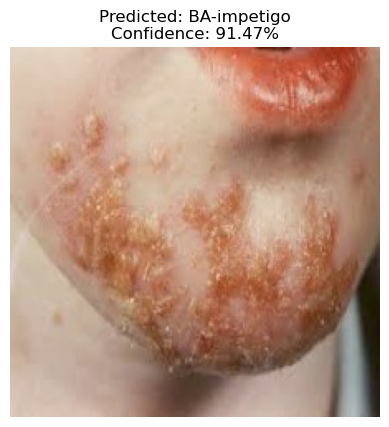

Predicted Class: BA-impetigo
Confidence: 91.4724


In [8]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 👇 Yahan apni test image ka path do
img_path = "skin-disease-datasaet/test_set/BA-impetigo/2_BA-impetigo (16).jpg"

# Image load karo
img = image.load_img(img_path, target_size=(224, 224))

# Array mein convert karo
img_array = image.img_to_array(img)

# Normalize karo (same as training)
img_array = img_array / 255.0

# Batch dimension add karo
img_array = np.expand_dims(img_array, axis=0)

# Prediction karo
predictions = model.predict(img_array)

# Highest probability wali class
predicted_index = np.argmax(predictions)

predicted_class = class_names[predicted_index]
confidence = np.max(predictions) * 100

# Image show karo
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.show()

print("Predicted Class:", predicted_class)
print("Confidence:", confidence)

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


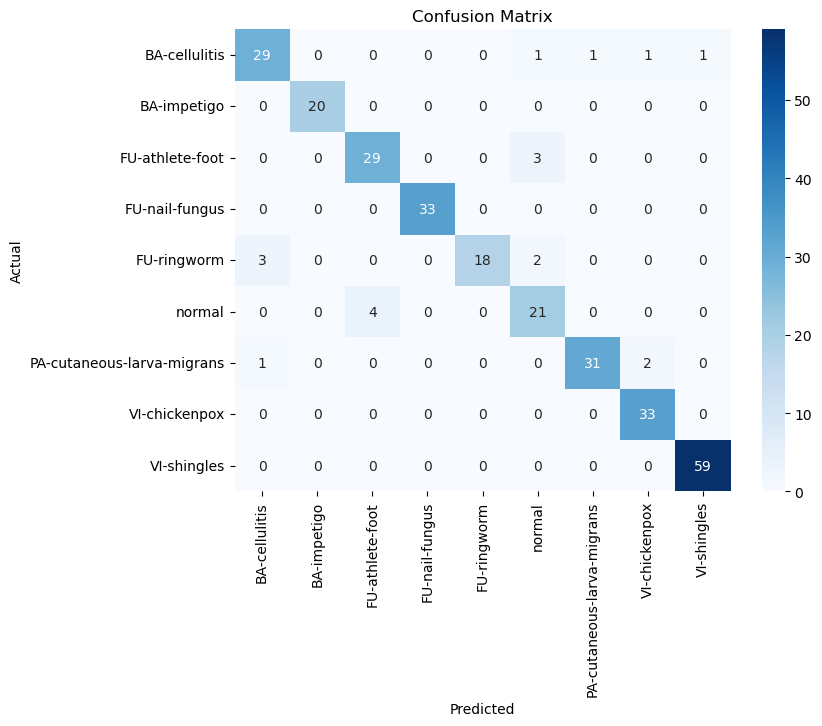

In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names
)

print(report)

                            precision    recall  f1-score   support

             BA-cellulitis       0.88      0.88      0.88        33
               BA-impetigo       1.00      1.00      1.00        20
           FU-athlete-foot       0.88      0.91      0.89        32
            FU-nail-fungus       1.00      1.00      1.00        33
               FU-ringworm       1.00      0.78      0.88        23
                    normal       0.78      0.84      0.81        25
PA-cutaneous-larva-migrans       0.97      0.91      0.94        34
             VI-chickenpox       0.92      1.00      0.96        33
               VI-shingles       0.98      1.00      0.99        59

                  accuracy                           0.93       292
                 macro avg       0.93      0.92      0.93       292
              weighted avg       0.94      0.93      0.93       292

